In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vtk_rw import read_vtk
from plotting import plot_surf_stat_map
from mayavi import mlab
from IPython.display import Image
from graphs import graph_from_mesh, subcluster_graph, adjacent_subcluster

/home/raid3/huntenburg/workspace/try_openblas/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def make_cluster_cmap(c):
    cmap = np.asarray(sns.color_palette('cubehelix', c-1))
    np.random.shuffle(cmap)
    cmap = np.concatenate((np.array([[0.4,0.4,0.4]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

Networkx can be used to create a graph given the nodes and faces / edges of a mesh. In graph representation several operations, such as finding subgraphs and connected components are implemented very fast in networkx, other algorithms like Djikstra's algorithm expect a graph representations as input. https://github.com/juhuntenburg/brainsurfacescripts/blob/master/graphs.py

In [4]:
mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
clustering_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/smooth_3/mask_025_5/rh_embed_10_kmeans_5.npy'

In [5]:
v, f, d = read_vtk(mesh_file)
clust = np.load(clustering_file)

In [6]:
x=v[:,0]
y=v[:,1]
z=v[:,2]
pal, pal_255 = make_cluster_cmap(int(clust.max()+1))

In [7]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,f,scalars=clust, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_255
mlab.draw()
mlab.show()

/usr/lib/python2.7/dist-packages/traits/has_traits.py:1928: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


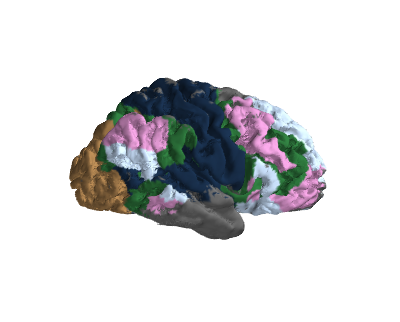

In [8]:
Image(filename='/home/raid3/huntenburg/networkx/fullclust_lat.png') 

### Creating a graph from a mesh

In [9]:
g = graph_from_mesh(v, f)

In [10]:
g.nodes()[:20]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [11]:
g.edges()[:10]

[(0, 2),
 (0, 4),
 (0, 13),
 (0, 15),
 (1, 48),
 (1, 2),
 (1, 3),
 (1, 12),
 (1, 13),
 (2, 3)]

### Adding information to the nodes and edges (using fast nodes.iter() / edges.iter())

In [12]:
g_plus = graph_from_mesh(v, f, node_coords=True, edge_length=True)

In [13]:
g_plus[0]

{2: {'length': 0.81546612437306087},
 4: {'length': 1.5342089166733375},
 13: {'length': 0.40169266859130143},
 15: {'length': 1.540420072577604},
 'coords': array([  56.285,  124.308,  139.362])}

In [14]:
g_plus[0][2]

{'length': 0.81546612437306087}

### Finding connected subclusters from an existing clustering

In [15]:
print v.shape
print clust.shape

(75589, 3)
(75589,)


In [16]:
print 'clust min',clust.min()
print 'clust max',clust.max()

clust min 0.0
clust max 5.0


In [17]:
subcluster = subcluster_graph(v, f, clust)

In [18]:
subcluster.shape

(75589, 6)

In [19]:
main=4
network=subcluster[:,main].copy()
for i in np.unique(network):
    if np.where(network==i)[0].shape[0] < 100:
        network[np.where(network==i)]=0

pal_net, pal_net_255 = make_cluster_cmap(int(np.unique(network).shape[0]))

In [ ]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,f,scalars=network, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_net_255
mlab.draw()
mlab.show()

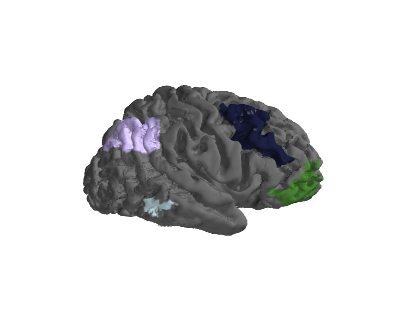

In [20]:
Image(filename='/home/raid3/huntenburg/networkx/subclust_4_lat.png') 

In [21]:
np.all(np.where(clust==4)[0]==np.where(subcluster[:,4]!=0)[0])

True

In [22]:
print subcluster[:,0].max()
print subcluster[:,5].max()

302.0
28.0


In [23]:
lengths = []
for i in range(int(subcluster[:,0].max()+1)):
    lengths.append(np.where(subcluster[:,0]==i)[0].shape[0])
lengths = np.asarray(lengths)

In [24]:
print 'min', lengths.min(), '(%ix)'%np.where(lengths==lengths.min())[0].shape[0]
print 'max',lengths.max()
print 'mean',lengths.mean()
print 'sdv',lengths.std()

min 1 (149x)
max 59361
mean 249.468646865
sdv 3497.77198932


In [25]:
subcluster_long = subcluster.copy()
for k in range(subcluster.shape[1]):
    for sub in range(int(subcluster[:,k].max()+1)):
        if np.where(subcluster[:,k]==sub)[0].shape[0] < 100:
            subcluster_long[:,k][np.where(subcluster[:,k]==sub)]=0

In [26]:
print subcluster_long[:,0].max()
print subcluster_long[:,5].max()

3.0
4.0


### Find unique pairs of spatially adjacent subclusters

In [27]:
unique_pairs = adjacent_subcluster(v, f, subcluster_long)

In [28]:
print unique_pairs

[('0_1', '1_6'), ('0_1', '3_1'), ('1_6', '3_1'), ('1_4', '0_1'), ('0_1', '2_1'), ('0_1', '1_1'), ('0_1', '4_2'), ('2_1', '1_4'), ('0_1', '5_3'), ('0_1', '4_5'), ('2_1', '5_2'), ('4_2', '1_4'), ('1_4', '5_2'), ('4_5', '5_3'), ('5_3', '3_1'), ('4_5', '1_5'), ('0_1', '1_5'), ('2_1', '1_5'), ('5_2', '4_2'), ('0_1', '1_3'), ('5_3', '1_5'), ('5_3', '2_2'), ('3_1', '2_2'), ('3_1', '1_3'), ('2_1', '5_3'), ('3_1', '1_7'), ('5_3', '1_2'), ('0_1', '1_7'), ('1_2', '2_1'), ('2_2', '1_2'), ('4_2', '1_1'), ('5_2', '4_3'), ('5_2', '1_1'), ('3_1', '5_1'), ('2_1', '5_1'), ('5_1', '1_2'), ('1_1', '5_4'), ('1_1', '4_4'), ('5_1', '2_2'), ('1_1', '2_1'), ('0_1', '4_7'), ('2_1', '5_4'), ('4_7', '1_3'), ('5_4', '4_4'), ('5_1', '4_1'), ('1_2', '4_1'), ('1_3', '5_1'), ('1_3', '4_6'), ('0_3', '1_1'), ('0_3', '4_3'), ('1_1', '4_3'), ('4_4', '0_2'), ('5_1', '4_7'), ('5_1', '4_6'), ('0_3', '5_2'), ('5_4', '0_2'), ('5_2', '0_2'), ('2_1', '0_2'), ('1_1', '0_2')]


In [29]:
neighbours = np.zeros_like(clust)
neighbours[np.where(subcluster[:,5]==1)]=1
neighbours[np.where(subcluster[:,4]==1)]=2
pal_sub, pal_sub_255 = make_cluster_cmap(3)

In [ ]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,f,scalars=neighbours, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_sub_255
mlab.draw()
mlab.show()

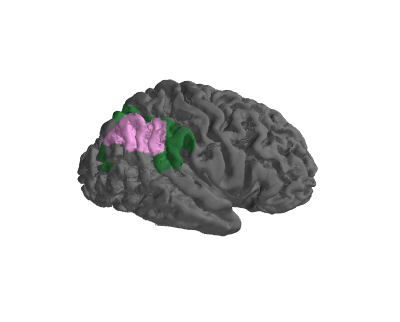

In [30]:
Image(filename='/home/raid3/huntenburg/networkx/adjacent_subcluster_5141_lat.png')